## clustering
achen@2021-5-24

In [1]:
import pandas as pd
import os
import glob
from Bio import Seq
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re
from scipy.stats import wilcoxon,mannwhitneyu
import numpy as np


In [104]:
import dask.dataframe as dd
from dask import delayed
def read_and_label_csv(filename):
    df_csv = pd.read_csv(filename,dtype={'best_mean_nm':str})
    df_csv['filename'] = os.path.basename(filename).replace('.csv','').replace('stat.','')
    return df_csv
fnames = glob.glob(f'../predict_cov//stats/*.csv')
dfs = [delayed(read_and_label_csv)(fname) for fname in fnames]
df = dd.from_delayed(dfs)
df = df.compute()
df['genome'] = df.src.apply(lambda d: '_'.join(d.split('-')[2].split('_')[:2]))
df['type'] = df['filename'].str[0]

In [106]:
meta = pd.read_csv('../data/smp.count.txt',sep='\t')
meta['smp'] = meta['smp'].str.replace('_1P','')
smp2count = dict(meta.set_index('smp')['count'])

In [107]:
genomeInfo = pd.read_csv('../refs/136Fstrains/datalist.csv',sep='\t')
genomeSize = dict(genomeInfo.set_index("Assembly")['Size(Mb)'])
df['relative abundance'] = df['best'] / (df.filename.map(smp2count)*df.genome.map(genomeSize))

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

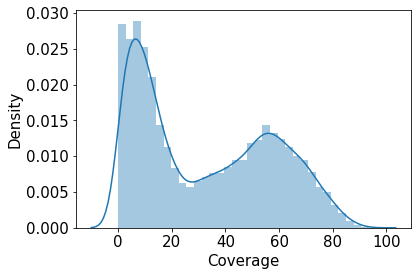

In [122]:
plt.figure(figsize=(6,4))

sns.distplot(df['sum-cov'])
plt.xlabel('Coverage',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

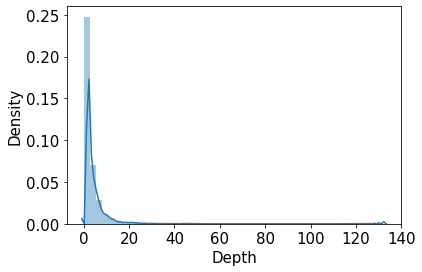

In [123]:
plt.figure(figsize=(6,4))
sns.distplot(df['mean_dep'])
plt.xlabel('Depth',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

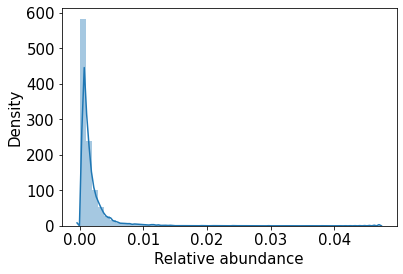

In [127]:
plt.figure(figsize=(6,4))
sns.distplot(df['relative abundance'],kde=True)
plt.xlabel('Relative abundance',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

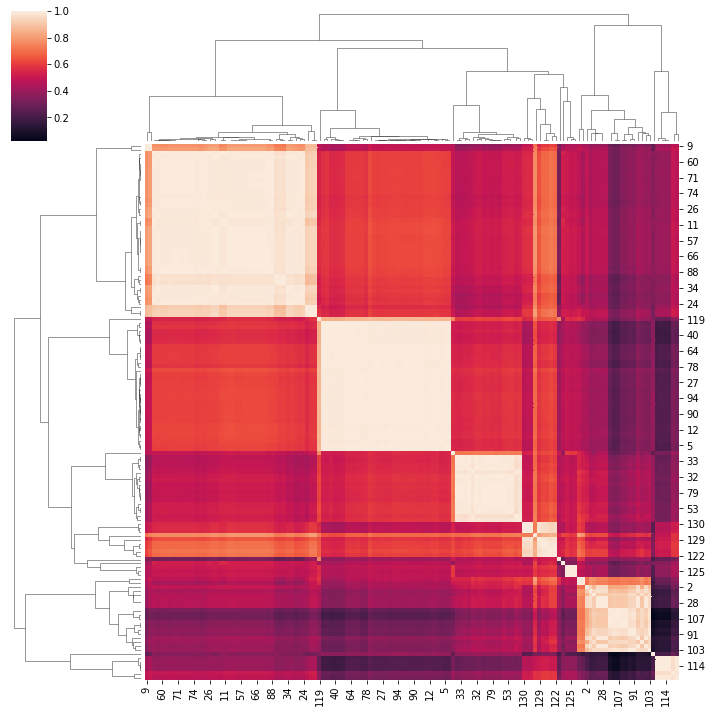

In [79]:
arrs_cov = []
smps = []
genomes = df.genome.unique()
for smp in df.filename.unique():
    smps.append(smp)
    arr = []
    for genome in genomes:
        tmpdf1 = df[df.filename==smp]
        tmpdf2 = tmpdf1[tmpdf1.src.str.contains(genome)]
        if len(tmpdf2)==0:
            arr.append(0)
        else:
            a = tmpdf2.reset_index(drop=True).loc[0]['sum-cov']
            arr += [a]
    arrs_cov.append(arr)
covdf_cov = pd.DataFrame(arrs_cov)
covdf_cov['smp'] = smps
covdf_cov = covdf_cov.set_index('smp')
g = sns.clustermap(covdf_cov.corr(method='pearson'))   

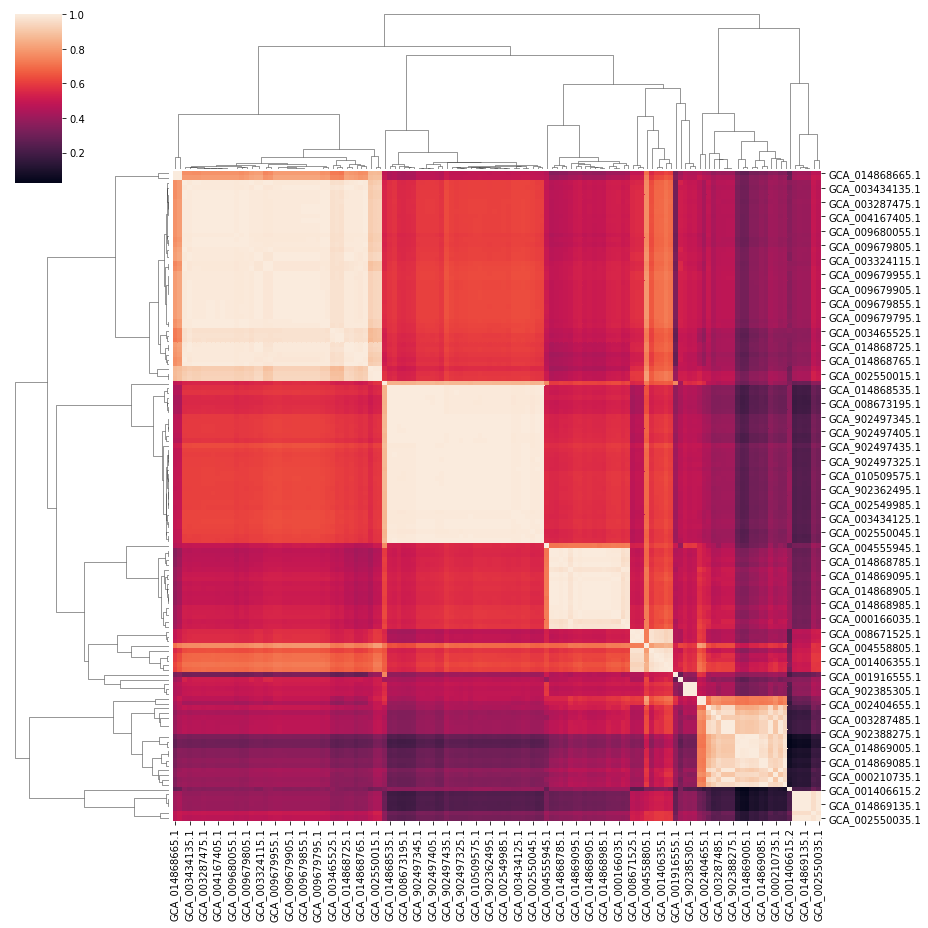

In [93]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations = covdf_cov.corr(method='pearson')
correlations_array = np.asarray(correlations)
correlations.index = genomes
correlations.columns = genomes

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,  figsize=(13, 13) )


In [94]:
fclust_lst = hierarchy.fcluster(col_linkage,t=5,criterion='maxclust')
pd.Series(fclust_lst).value_counts()

1    44
2    34
3    32
4    19
5     7
dtype: int64